# Python Learn by Doing: ENSO, Your Turn! Option 1 Answer Key

**Developed By:** Dr. Kerrie Geil, Mississippi State University

**Original Development Date:** July 2024

**Package Requirements:** xarray, netcdf4, numpy, pandas, scipy, matplotlib, cartopy, jupyter

**Links:** **[OSF project link](https://osf.io/zhpd5/)**, [link to this notebook on github](https://github.com/kerriegeil/MSU_py_training/blob/main/learn_by_doing/enso/assignments/enso_analysis_option1.ipynb)

---
**Assignment:**

Repeat science question 3 using October-March for the winter months. Show the difference between results using DJF and results using ONDJFM.


&emsp;Hints:
- hint about Oct-Mar
- Plot a difference map of the DJF results minus the ONDJFM results

# Importing Python Packages and Defining Your Workspace


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as ss
from scipy.signal import detrend
import rioxarray as rio

import warnings
import os
from urllib.request import urlretrieve
import sys

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LongitudeFormatter

In [2]:
# create a folder for data downloads
if not os.path.exists('../data'):
    os.makedirs('../data')

In [3]:
# filenames to save data to
nino_f = '../data/nino34_anomalies_monthly_NOAA.txt'
sst_f = '../data/sst_monthly_COBE2_JMA.nc'
t_f = '../data/tavg_monthly_BerkeleyEarth.nc'
pr_f = '../data/precip_monthly_PRECL_NOAA.nc'

# Data Cleaning

In [4]:
# data cleaning copied from enso_analysis.ipynb

year_start = '1948'
year_end = '2023'
base_start = '1981'
base_end = '2010'

# Nino3.4 index
nino_raw=pd.read_csv(nino_f,sep=r'\s+',skiprows=1,skipfooter=7,header=None,index_col=0,na_values=-99.99,engine='python')
nino=nino_raw.to_numpy().flatten()
dates=pd.date_range('1870-01-01','2024-12-01',freq='MS')
nino=xr.DataArray(nino,name='nino',dims='time',coords={'time':dates})
nino.attrs['standard_name']='nino3.4 index'
nino.attrs['units']='C'
nino=nino.sel(time=slice(year_start,year_end))

# precipitation data
ds=xr.open_dataset(pr_f)
pr=ds.precip
pr=pr.sel(time=slice(year_start,year_end))
pr=pr.reindex(lat=pr.lat[::-1])
pr.coords['lon']=xr.where(pr.coords['lon']>180,pr.coords['lon']-360,pr.coords['lon'])
roll_len=len(pr.lon)//2
pr=pr.roll(lon=roll_len,roll_coords=True)
pr_base=pr.sel(time=slice(base_start,base_end)) 
pr_clim=pr_base.groupby(pr_base.time.dt.month).mean('time') 
pr_anom=pr.groupby(pr.time.dt.month) - pr_clim  
pr_anom.attrs['standard_name']='pr anomaly'
pr_anom.attrs['units']='mm/day'

# temperature data
ds=xr.open_dataset(t_f)
dates=pd.date_range('1750-01-01','2024-03-01',freq='MS')
ds['time']=dates
ds=ds.rename({'month_number':'month','latitude':'lat','longitude':'lon'})
t_anom_5180=ds.temperature
clim_5180=ds.climatology
t=t_anom_5180.groupby(t_anom_5180.time.dt.month)+clim_5180
t_base=t.sel(time=slice(base_start,base_end))  
clim_8110 = t_base.groupby(t_base.time.dt.month).mean('time')  
t_anom=t.groupby(t.time.dt.month)-clim_8110
t_anom=t_anom.sel(time=slice(year_start,year_end))
t_anom=t_anom.rename('tavg')
t_anom.attrs['standard_name']='T anomaly'
t_anom.attrs['units']='C'

# check first and last time is the same for all data
variables=[nino, pr_anom, t_anom]
for var in variables:
    print(var.name, var.time[0].data,var.time[-1].data)

# clean up
del nino_raw, dates, ds, pr, pr_base, pr_clim, t, t_anom_5180, clim_5180, t_base, clim_8110, variables

nino 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000
precip 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000
tavg 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000


# Begin Main Analysis

First, we need to know when El Nino and La Nina events occurred so we'll copy over code from question 1 in enso_analysis.ipynb (How many strong El Nino and La Nina events have occurred from 1948 to 2023?). We only need the part of the code that creates the array `nino_events` 

In [5]:
# copied from question 1 in enso_analysis.ipynb

# constants based on our criteria
nmonths=5
event_thresh=0.6

# first calculate the 5-month rolling mean
nino_rollmean=nino.rolling(time=nmonths,center=True).mean()

# create an array to hold our results and initialize to nan
# this array is where we will fill values with +1,-1
nino_events=nino_rollmean.copy() 
nino_events[:]=np.nan

# now loop through months and fill +1, -1 for windows of 5 months that meet our criteria
for i,value in enumerate(nino_rollmean):
    # La Nina conditions
    if  value < -event_thresh:
        
        # possible La Nina conditions, look forward 4 more months
        window=nino_rollmean[i:i+nmonths]
        if all(window < -event_thresh):
            nino_events[i:i+nmonths] = -1

    # El Nino conditions
    if  value > event_thresh:
        # possible El Nino conditions, look forward 4 more months
        window=nino_rollmean[i:i+nmonths]
        if all(window > event_thresh):
            nino_events[i:i+nmonths]=1    

Next, we need to build our composites and determine statistical significance. We'll copy over the relevant code from question 3 in enso_analysis.ipynb into a new function called `composite_and_pval` since we'll be running the same computation multiple times.

In [6]:
# a function to compute composites and pvals for different seasons
def composite_and_pval(nino_events,anom,phase,month_int_list):
    ''' 
    inputs
    nino_events :: the nino_events array of -1,+1 that we created in the previous step
    anom :: the temperature or precipitation anomaly data that we prepared in the data cleaning section
    phase :: string, either 'nino' or 'nina'
    month_int_list :: list of integers, months to include in the composite
    
    returns
    var_phase_composite :: the data composite for the appropriate enso phase and season
    var_pval :: the pvalues from a t-test for differences in means between samples of 
                phase months (nino or nina) in the requested season (month_int_list) and 
                non-phase months in the requested season
    '''
    if phase=='nino':
        phase_int=1
    elif phase=='nina':
        phase_int=-1
    else:
        sys.exit('phase can only be nino or nina')

    print(f'computing a {phase} composite for {anom.name} months {month_int_list}...')

    # composite for the approprate enso phase and season
    var_phase=anom.where(nino_events==phase_int,drop=True)
    var_phase_season=var_phase.sel(time=var_phase.time.dt.month.isin(month_int_list)) # sample 1
    var_phase_composite=var_phase_season.mean('time',keep_attrs=True)

    # sample 2 for t-test
    var_other = anom.where(nino_events!=phase_int,drop=True)
    var_other_season = var_other.sel(time=var_other.time.dt.month.isin(month_int_list))

    print(f'{anom.name} {phase} and non-{phase} sample sizes:',var_phase_season.shape[0],var_other_season.shape[0]) 
    
    # significance test
    var_sigtest = ss.ttest_ind(var_phase_season, var_other_season, axis=0, equal_var=False)
    var_pval = xr.DataArray(var_sigtest.pvalue, coords={'lat':('lat',var_phase.coords['lat'].data),'lon':('lon',var_phase.coords['lon'].data)})

    return var_phase_composite,var_pval

Now we calculate the following composites with pvalues:
- el nino temperature anomaly for DJF
- el nino temperature anomaly for ONDJFM
- el nino precipitation anomaly for DJF
- el nino precipitation anomaly for ONDJFM

In [7]:
t_nino_DJF_composite, t_nino_DJF_pval = composite_and_pval(nino_events,
                                                           t_anom,
                                                           phase='nino',
                                                           month_int_list=[12,1,2])

t_nino_ONDJFM_composite, t_nino_ONDJFM_pval = composite_and_pval(nino_events,
                                                                 t_anom,
                                                                 phase='nino',
                                                                 month_int_list=[10,11,12,1,2,3])

pr_nino_DJF_composite, pr_nino_DJF_pval = composite_and_pval(nino_events,
                                                           pr_anom,
                                                           phase='nino',
                                                           month_int_list=[12,1,2])

pr_nino_ONDJFM_composite, pr_nino_ONDJFM_pval = composite_and_pval(nino_events,
                                                                 pr_anom,
                                                                 phase='nino',
                                                                 month_int_list=[10,11,12,1,2,3])

computing a nino composite for tavg months [12, 1, 2]...
tavg nino and non-nino sample sizes: 44 184
computing a nino composite for tavg months [10, 11, 12, 1, 2, 3]...
tavg nino and non-nino sample sizes: 86 370
computing a nino composite for precip months [12, 1, 2]...
precip nino and non-nino sample sizes: 44 184
computing a nino composite for precip months [10, 11, 12, 1, 2, 3]...
precip nino and non-nino sample sizes: 86 370


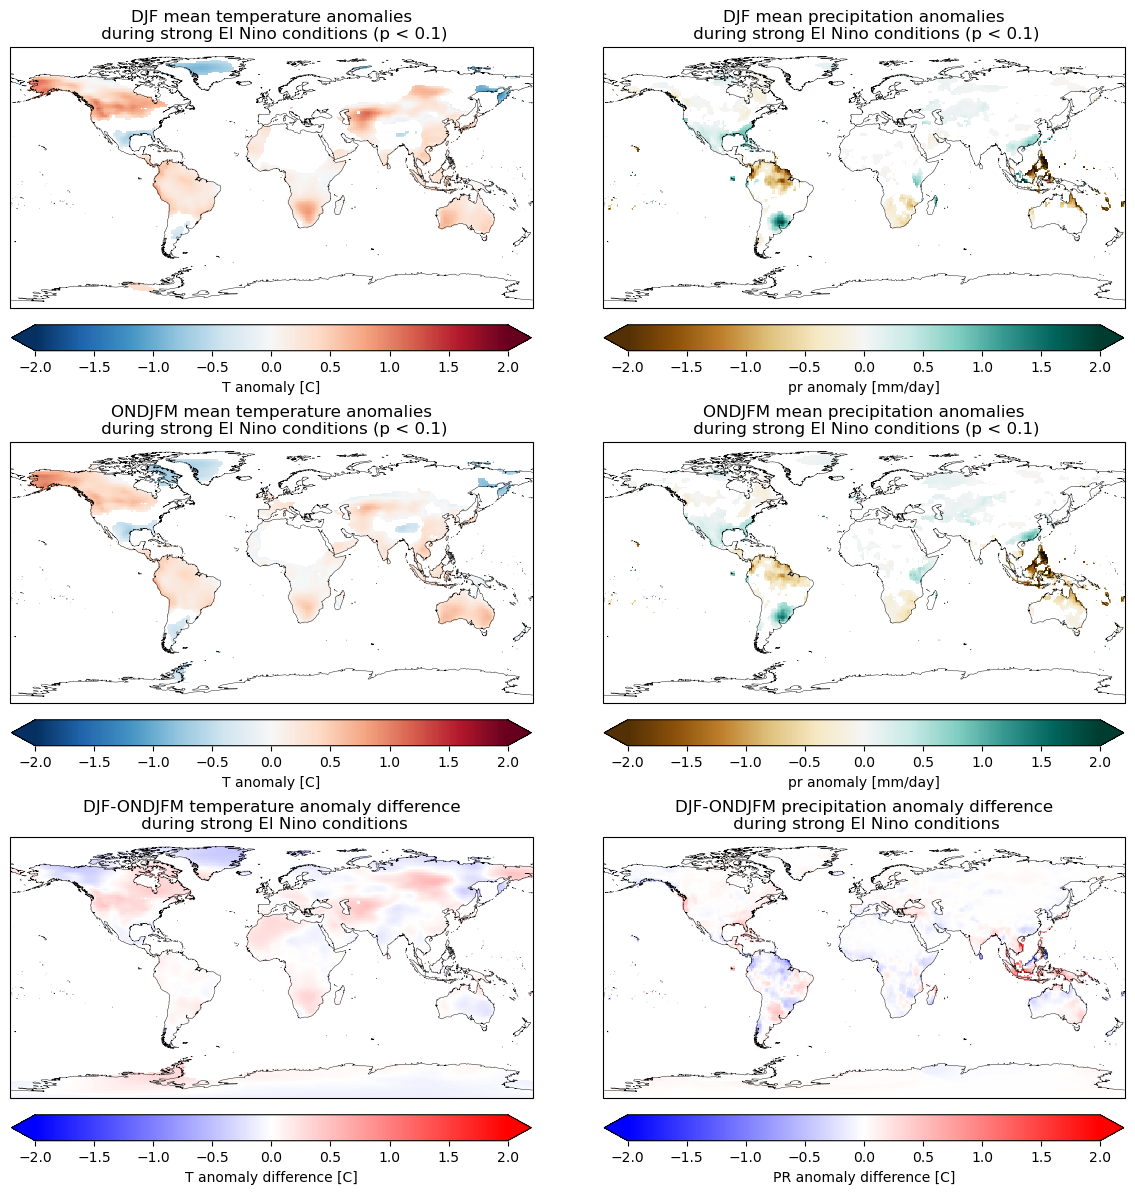

In [8]:
# make plots using pval < 0.1
pval=0.1

fig=plt.figure(figsize=(12,12))

# DJF plots
ax=fig.add_subplot(321,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nino_DJF_composite.where(t_nino_DJF_pval<pval).plot(vmin=-2, vmax=2, extend='both',cmap='RdBu_r',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'DJF mean temperature anomalies\n during strong El Nino conditions (p < {pval})')

ax=fig.add_subplot(322,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
pr_nino_DJF_composite.where(pr_nino_DJF_pval<pval).plot(vmin=-2, vmax=2, extend='both',cmap='BrBG',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'DJF mean precipitation anomalies\n during strong El Nino conditions (p < {pval})')

# ONDJFM plots
ax=fig.add_subplot(323,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nino_ONDJFM_composite.where(t_nino_ONDJFM_pval<pval).plot(vmin=-2, vmax=2, extend='both',cmap='RdBu_r',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'ONDJFM mean temperature anomalies\n during strong El Nino conditions (p < {pval})')

ax=fig.add_subplot(324,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
pr_nino_ONDJFM_composite.where(pr_nino_ONDJFM_pval<pval).plot(vmin=-2, vmax=2, extend='both',cmap='BrBG',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'ONDJFM mean precipitation anomalies\n during strong El Nino conditions (p < {pval})')

# difference plots
ax=fig.add_subplot(325,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
(t_nino_DJF_composite-t_nino_ONDJFM_composite).plot(vmin=-2, vmax=2,extend='both',cmap='bwr',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05,'label':'T anomaly difference [C]'})
plt.title(f'DJF-ONDJFM temperature anomaly difference\n during strong El Nino conditions')

ax=fig.add_subplot(326,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
(pr_nino_DJF_composite-pr_nino_ONDJFM_composite).plot(vmin=-2, vmax=2,extend='both',cmap='bwr',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05,'label':'PR anomaly difference [C]'})
plt.title(f'DJF-ONDJFM precipitation anomaly difference\n during strong El Nino conditions')

plt.tight_layout()
plt.show()

repeat for La Nina

In [9]:
t_nina_DJF_composite, t_nina_DJF_pval = composite_and_pval(nino_events,
                                                           t_anom,
                                                           'nina',
                                                           [12,1,2])

t_nina_ONDJFM_composite, t_nina_ONDJFM_pval = composite_and_pval(nino_events,
                                                                 t_anom,
                                                                 'nina',
                                                                 [10,11,12,1,2,3])

pr_nina_DJF_composite, pr_nina_DJF_pval = composite_and_pval(nino_events,
                                                           pr_anom,
                                                           'nina',
                                                           [12,1,2])

pr_nina_ONDJFM_composite, pr_nina_ONDJFM_pval = composite_and_pval(nino_events,
                                                                 pr_anom,
                                                                 'nina',
                                                                 [10,11,12,1,2,3])

computing a nina composite for tavg months [12, 1, 2]...
tavg nina and non-nina sample sizes: 59 169
computing a nina composite for tavg months [10, 11, 12, 1, 2, 3]...
tavg nina and non-nina sample sizes: 118 338
computing a nina composite for precip months [12, 1, 2]...
precip nina and non-nina sample sizes: 59 169
computing a nina composite for precip months [10, 11, 12, 1, 2, 3]...
precip nina and non-nina sample sizes: 118 338


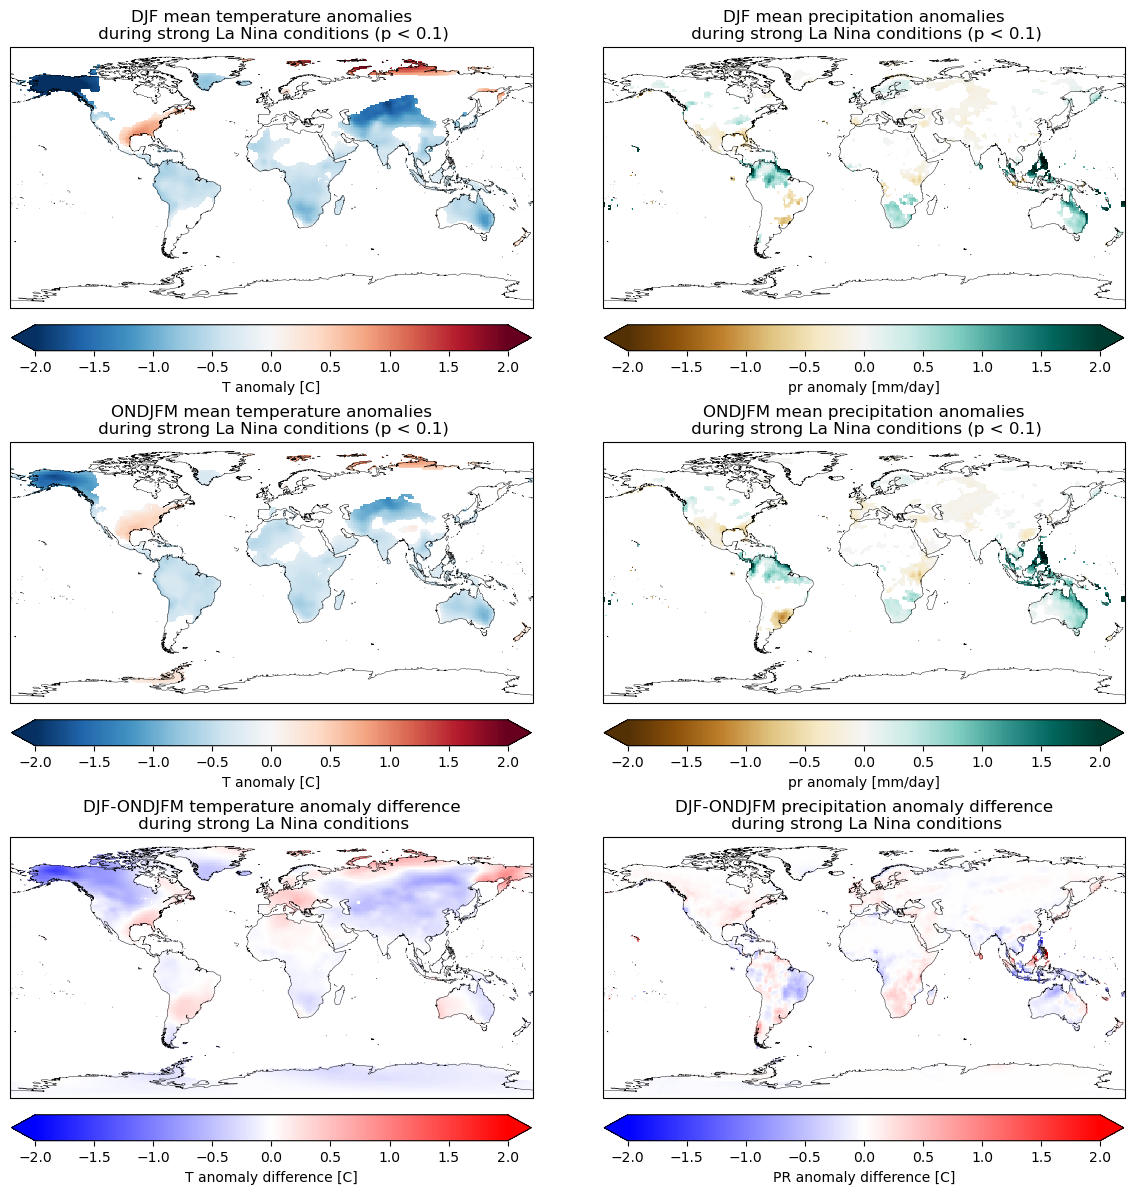

In [10]:
# make plots using pval < 0.1
pval=0.1

fig=plt.figure(figsize=(12,12))

# DJF plots
ax=fig.add_subplot(321,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nina_DJF_composite.where(t_nina_DJF_pval<pval).plot(vmin=-2, vmax=2, extend='both',cmap='RdBu_r',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'DJF mean temperature anomalies\n during strong La Nina conditions (p < {pval})')

ax=fig.add_subplot(322,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
pr_nina_DJF_composite.where(pr_nina_DJF_pval<pval).plot(vmin=-2, vmax=2, extend='both',cmap='BrBG',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'DJF mean precipitation anomalies\n during strong La Nina conditions (p < {pval})')

# ONDJFM plots
ax=fig.add_subplot(323,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nina_ONDJFM_composite.where(t_nina_ONDJFM_pval<pval).plot(vmin=-2, vmax=2, extend='both',cmap='RdBu_r',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'ONDJFM mean temperature anomalies\n during strong La Nina conditions (p < {pval})')

ax=fig.add_subplot(324,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
pr_nina_ONDJFM_composite.where(pr_nina_ONDJFM_pval<pval).plot(vmin=-2, vmax=2, extend='both',cmap='BrBG',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'ONDJFM mean precipitation anomalies\n during strong La Nina conditions (p < {pval})')

# difference plots
ax=fig.add_subplot(325,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
(t_nina_DJF_composite-t_nina_ONDJFM_composite).plot(vmin=-2, vmax=2,extend='both',cmap='bwr',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05,'label':'T anomaly difference [C]'})
plt.title(f'DJF-ONDJFM temperature anomaly difference\n during strong La Nina conditions')

ax=fig.add_subplot(326,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
(pr_nina_DJF_composite-pr_nina_ONDJFM_composite).plot(vmin=-2, vmax=2,extend='both',cmap='bwr',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05,'label':'PR anomaly difference [C]'})
plt.title(f'DJF-ONDJFM precipitation anomaly difference\n during strong La Nina conditions')

plt.tight_layout()
plt.show()

Is there a big difference between where positive and negative anomalies occur in the DJF vs ONDJFM plots?

We can see that the spatial patterns of temperature and precipitation anomalies during strong El Nino and La Nina events in boreal cool months is robust. There is not much difference in the location of where anomalies occur due to the choice of using DJF or ONDJFM for boreal cool months.

What do the red and blue areas on the difference map mean?

Personally, I find these types of difference maps a bit confusing because for example, a blue area on the difference map can mean 3 things: 1) the area has a negative anomaly for DJF and a less negative anomaly for ONDJFM (like Alaska La Nina temperature), 2) the area has a negative anomaly for DJF and a positive anomaly for ONDJFM (), or 3) the area has a positive anomaly for DJF and a larger positive anomaly for ONDJFM (like eastern Australia El Nino temperature). The situation is similar for the red areas on these difference maps. That's too much to think about simultaneously. 


What kind of plot could be more helpful?

Depending on what exactly I'm looking to quantify I often like to make plots of the difference in magnitude (so take absolute value of everything before differencing). 

Or, plotting the difference for locations where the sign of the anomalies are the same (e.g. positive for both DJF and ONDJFM) but plotting some other color to indicate where the sign of the anomalies change (e.g. positive DJF anomaly, negative ONDJFM anomaly). This can give a better idea of how different the ONDJFM results are from the DJF results. Of course, interpretation of this kind of plot can be difficult too since the sign of the anomaly is more likely to change in areas that are not statistically signficant. We could mask out where both DJF and ONDJFM anomalies and not significant to aid in our interpretation.

Let's take a look.

In [27]:
# a function to find where the sign of the anomaly changes
def anom_sign_change(anom_DJF,pval_DJF,anom_ONDJFM,pval_ONDJFM,sig_lvl):
    ''' 
    inputs
    anom_DJF :: the nino or nina temperature or precipitation anomaly composite for DJF
    anom_ONDJFM :: the nino or nina temperature or precipitation anomaly composite for ONDJFM
    pval_DJF :: the nino or nina temperature or precipitation anomaly composite pvalues for DJF
    pval_ONDJFM :: the nino or nina temperature or precipitation anomaly composite pvalues for ONDJFM
    sig_lvl :: the pvalue that is considered statistically significant
    
    returns
    anom_sign_change :: an array with three possible values indicating how the sign of the anomaly 
                        changes between the results for DJF and ONDJFM. This array is masked to 
                        only show grid cells that are statistically significant in both the DJF
                        and ONDJFM composite pvalues 
                        0 --> the sign of the anomaly flip flops
                        -2 --> the sign of the anomaly is always negative
                        +2 --> the sign of the anomaly is always positive
    '''

    # arrays where negative anomalies --> -1, positive anomalies --> +1
    anom_DJF_posneg = xr.where(anom_DJF>=0,1,-1)
    anom_ONDJFM_posneg = xr.where(anom_ONDJFM>=0,1,-1)

    # an array with three possible values indicating how the sign of 
    # the anomaly changes between the results for DJF and ONDJFM
    anom_sign_change = anom_DJF_posneg + anom_ONDJFM_posneg
    anom_sign_change = anom_sign_change.where(np.isfinite(anom_DJF)) # put nans back

    # make a mask out of DJF and ONDJFM pvalues
    # mask = 1 where both pvalues are significant
    mask=xr.where( (pval_DJF<=sig_lvl)&(pval_ONDJFM<=sig_lvl),1,0)

    # apply the mask
    anom_sign_change=anom_sign_change.where(mask)

    return anom_sign_change

In [37]:
pval=0.1
t_nino_sign_change = anom_sign_change(t_nino_DJF_composite,t_nino_DJF_pval,t_nino_ONDJFM_composite,t_nino_ONDJFM_pval,pval)
pr_nino_sign_change = anom_sign_change(pr_nino_DJF_composite,pr_nino_DJF_pval,pr_nino_ONDJFM_composite,pr_nino_ONDJFM_pval,pval)

t_nina_sign_change = anom_sign_change(t_nina_DJF_composite,t_nina_DJF_pval,t_nina_ONDJFM_composite,t_nina_ONDJFM_pval,pval)
pr_nina_sign_change = anom_sign_change(pr_nina_DJF_composite,pr_nina_DJF_pval,pr_nina_ONDJFM_composite,pr_nina_ONDJFM_pval,pval)

Text(0.5, 1.0, 'difference in the sign of DJF vs ONDJFM precipitation\n anomalies during strong La Nina conditions (p < 0.1)')

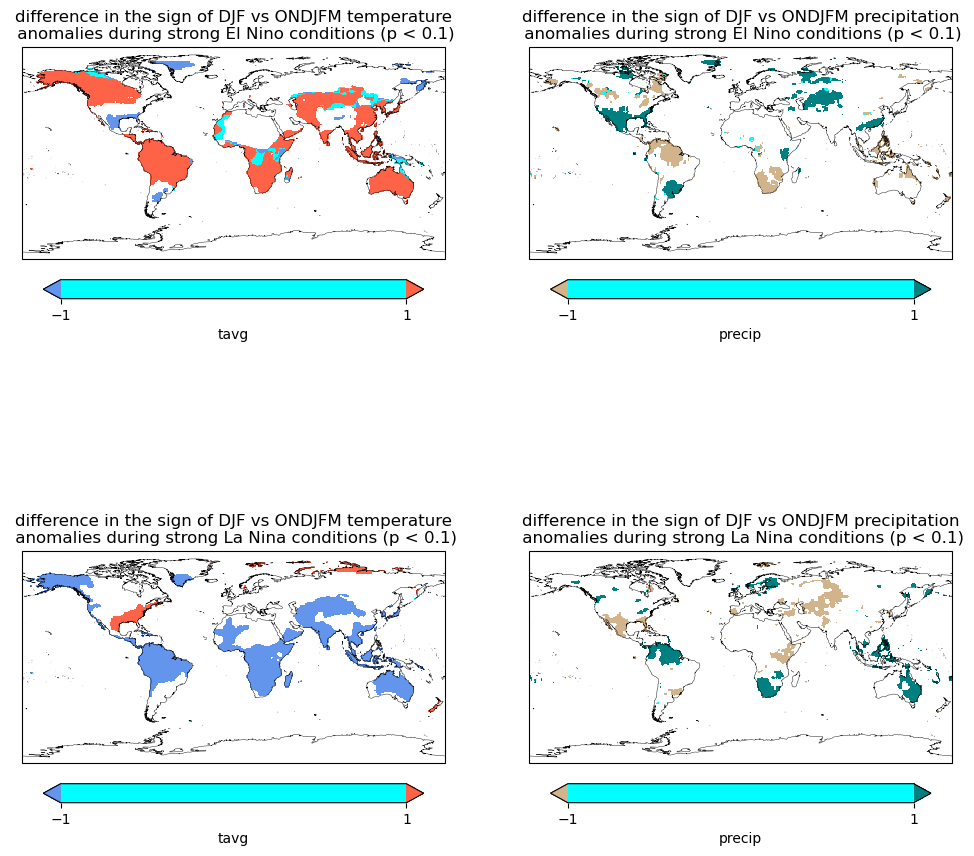

In [43]:
fig=plt.figure(figsize=(12,12))

t_colors=['cornflowerblue','cyan','tomato']
pr_colors=['tan','cyan','teal']
levels=[-1,1]

ax=fig.add_subplot(221,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nino_sign_change.plot(levels=levels,colors=t_colors, cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})#,'ticks':['a','b']})#['always\nnegative','always\npositive']})
plt.title(f'difference in the sign of DJF vs ONDJFM temperature\n anomalies during strong El Nino conditions (p < {pval})')
# cb = plt.colorbar(plot,shrink=0.9,orientation="horizontal", pad=0.05)
# cb.set_label(label='Temperature ($^{\circ}$C)', size='large', weight='bold')
# cb.ax.tick_params(labelsize='large')

ax=fig.add_subplot(222,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
pr_nino_sign_change.plot(levels=levels,colors=pr_colors, cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'difference in the sign of DJF vs ONDJFM precipitation\n anomalies during strong El Nino conditions (p < {pval})')

ax=fig.add_subplot(223,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nina_sign_change.plot(levels=levels,colors=t_colors, cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'difference in the sign of DJF vs ONDJFM temperature\n anomalies during strong La Nina conditions (p < {pval})')

ax=fig.add_subplot(224,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
pr_nina_sign_change.plot(levels=levels,colors=pr_colors, cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'difference in the sign of DJF vs ONDJFM precipitation\n anomalies during strong La Nina conditions (p < {pval})')

In [ ]:
# now put labels on the colorbar "always negative" "sign change" "always positive"